In [1]:
#### Dependencies ####

import numpy as np
import logging
import sys
import time
import joblib
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM # Only necessary for feature extraction.

# Repository imports
from ridge_utils.ridge import bootstrap_ridge
import ridge_utils.npp
from ridge_utils.util import make_delayed
from ridge_utils.dsutils import make_word_ds
from ridge_utils.DataSequence import DataSequence
from ridge_utils.tokenization_helpers import generate_efficient_feat_dicts_opt
from ridge_utils.tokenization_helpers import convert_to_feature_mats_opt

### Some extra helper functions

zscore = lambda v: (v - v.mean(0)) / v.std(0)
zscore.__doc__ = """Z-scores (standardizes) each column of [v]."""
zs = zscore

## Matrix corr -- find correlation between each column of c1 and the corresponding column of c2
mcorr = lambda c1, c2: (zs(c1) * zs(c2)).mean(0)
mcorr.__doc__ = """Matrix correlation. Find the correlation between each column of [c1] and the corresponding column of [c2]."""

### Ignore irrelevant warnings that muck up the notebook
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Some parameters
NUM_VOX = 95556 # Number of voxels in the subject we plan to use
NUM_TRS = 790 # Number of TRs across 3 test stories
trim_start = 50 # Trim 50 TRs off the start of the story
trim_end = 5 # Trim 5 off the back
ndelays = 4 # We use 4 FIR delays (2 seconds, 4 seconds, 6 seconds, 8 seconds)
delays = range(1, ndelays + 1)

/n/home04/cfang/.conda/envs/sae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from configs import engram_dir, allstories
import os

box_dir = os.path.join(engram_dir, 'huth_box/')

In [3]:
### Running a basic semantic encoding model built from OPT layer 33 ###

# We are going to test our model on one of our held-out stories, "wheretheressmoke".
Tstories = ['wheretheressmoke']

# Load the precomputed OPT model hidden states from the Box
# From semantic_features folder
features = joblib.load(os.path.join(box_dir, "stored_activations", "downsampled_featureseqs_opt33b_layer33.jbl"))

# Trim and zscore the model features
Tstim = np.nan_to_num(np.vstack([ridge_utils.npp.zs(features[story][trim_start:-trim_end]) for story in Tstories]))

# Add FIR delays
delTstim = make_delayed(Tstim, delays)

# Load the linear encoding model weights for subject S02
# From ridge_weights folder
wt = joblib.load(os.path.join(box_dir, "stored_activations", "S3_opt33b_wts_layer33.jbl.jbl"))

# Dot the weights with the features to get voxelwise model predictions
pred = np.dot(delTstim,  wt)

In [4]:
wt.shape

(28672, 95556)

In [5]:
tensessions = joblib.load(os.path.join(box_dir, "stored_activations", "tensessions_wheretheressmoke_S03.jbl"))

In [6]:
tensessions.shape

(10, 291, 95556)

In [7]:
pred.shape

(251, 95556)

In [8]:
np.random.seed(0)
selected_features = np.random.choice(pred.shape[1], size=5000, replace=False)
np.random.seed()
_pred = pred[:, selected_features]
_tensessions = tensessions[:, 40:, selected_features]


In [9]:
def spe_and_cc_norm(orig_data, data_pred, data_norm=True, max_flooring=None):
    '''
    Computes the signal power explained and the cc_norm of a model given the observed and predicted values
    Assumes normalization unless data_norm is set to False
    
    orig_data: 3D numpy array (trials, timepoints, voxels)
    
    data_pred: 2D numpy array (timepoints, voxels)
    
    data_norm: bool -> Set to False if not pre-normalized
    
    max_flooring: None/float (0-1) -> If not None, compute cc_norm in an alternate way that floors cc_max by max_flooring.
    This is helpful to clean up bad voxels that are not at all language selective.
    
    According to Schoppe: https://www.frontiersin.org/articles/10.3389/fncom.2016.00010/full
    '''
    y = np.mean(orig_data, axis=0)
    num_trials = len(orig_data)
    if not data_norm:
        variance_across_time = np.var(orig_data, axis=1, ddof=1)
        TP = np.mean(variance_across_time, axis=0)
    else:
        TP = np.zeros(orig_data.shape[2]) + 1
    SP = (1 / (num_trials-1)) * ((num_trials * np.var(y, axis=0, ddof=1)) - TP) 
    SPE_num = (np.var(y, axis=0, ddof=1) - np.var(y - data_pred, axis=0, ddof=1)) 
    SPE = (np.var(y, axis=0, ddof=1) - np.var(y - data_pred, axis=0, ddof=1)) / SP
    y_flip = np.swapaxes(y, axis1=0, axis2=1)
    data_flip = np.swapaxes(data_pred, axis1=0, axis2=1)
    covs = np.zeros(y_flip.shape[0])
    for i, row in enumerate(y_flip):
        covs[i] = np.cov(y_flip[i], data_flip[i])[0][1]
    cc_norm =  np.sqrt(1/SP) * (covs / np.sqrt(np.var(data_pred, axis=0, ddof=1)))
    cc_max = None
    if max_flooring is not None:
        cc_max = np.nan_to_num(1 / (np.sqrt(1 + ((1/num_trials) * ((TP/SP)-1)))))
        #cc_max = np.maximum(cc_max, np.zeros(cc_max.shape) + max_flooring)
        corrs = np.zeros(y_flip.shape[0])
        for i, row in enumerate(y_flip):
            corrs[i] = np.corrcoef(y_flip[i], data_flip[i])[0][1]
        cc_norm = corrs / cc_max
    return SPE, cc_norm, cc_max, corrs


In [10]:
SPE, cc_norm, cc_max, corrs_unnorm = spe_and_cc_norm(_tensessions, _pred, max_flooring=0.25)

In [11]:
print(cc_norm)
print(cc_max)
print(corrs_unnorm)


[ 0.38781168 -0.14266981  0.22406386 ...  0.28726077  0.5865962
  0.38672965]
[0.78707599 0.44049137 0.48035841 ... 0.66926356 0.54646858 0.20779704]
[ 0.30523726 -0.06284482  0.10763096 ...  0.19225316  0.32055639
  0.08036128]


In [13]:
cc_norm = np.array(cc_norm)
print((cc_norm == np.inf).sum())
print((cc_norm == -np.inf).sum())

478
169


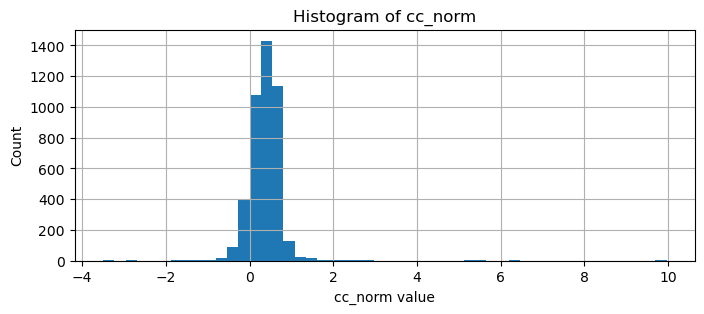

Mean cc_norm: 0.369
Median cc_norm: 0.377
Std cc_norm: 0.396


In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
cc_norm_finite = cc_norm[~np.isinf(cc_norm)]
plt.hist(cc_norm_finite, bins=50)
plt.title('Histogram of cc_norm')
plt.xlabel('cc_norm value')
plt.ylabel('Count')
plt.grid(True)
plt.show()

print(f"Mean cc_norm: {np.mean(cc_norm_finite):.3f}")
print(f"Median cc_norm: {np.median(cc_norm_finite):.3f}") 
print(f"Std cc_norm: {np.std(cc_norm_finite):.3f}")

